<a href="https://colab.research.google.com/github/SeoyoungOhMe/BiometricsSecurity/blob/main/06_fingerprint_upload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm

import fingerprint as fp

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

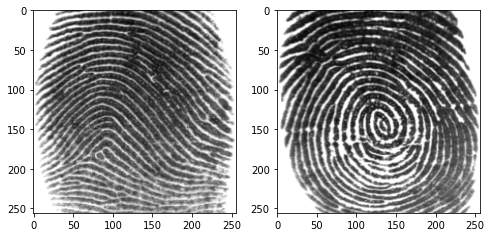

In [ ]:
img1 = cv2.imread('./data/001_00.png', 0)
img2 = cv2.imread('./data/002_00.png', 0)

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')


# Pose - Affine transform

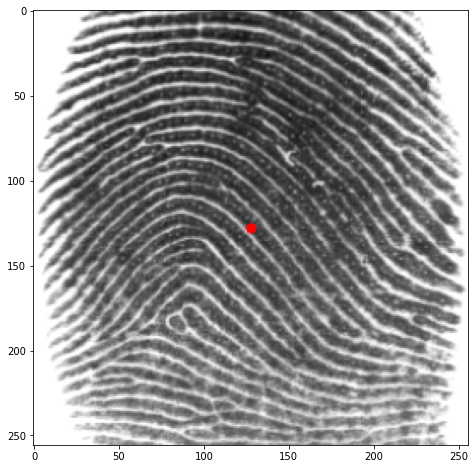

In [ ]:
# rotation & translation
center = (128, 128)
angle = 45
scale = 1.
tx = 0
ty = 0

img_show = cv2.circle(cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR), center, 3, (255, 0, 0), -1)
plt.imshow(img_show)

Rotation matrix
[[  0.70710678   0.70710678 -53.01933598]
 [ -0.70710678   0.70710678 128.        ]
 [  0.           0.           1.        ]]
Affine matrix w tr vec
[[  0.70710678   0.70710678 -53.01933598]
 [ -0.70710678   0.70710678 128.        ]
 [  0.           0.           1.        ]]


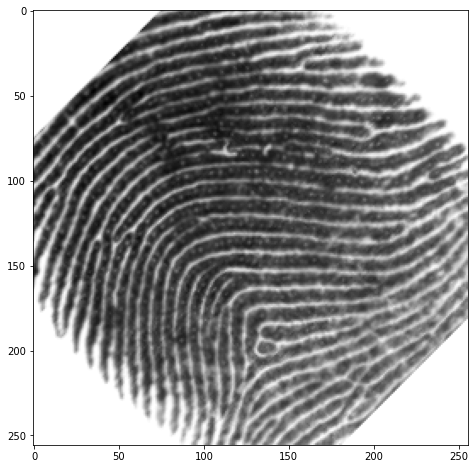

In [ ]:
# rotation matrix
center_mat = np.array((
    [1, 0, -128],
    [0, 1, -128],
    [0, 0, 1]
))
rot_10_mat = np.array((
    [np.cos(angle * np.pi / 180), np.sin(angle * np.pi / 180), 0],
    [-np.sin(angle * np.pi / 180), np.cos(angle * np.pi / 180), 0],
    [0, 0, 1]
))
center_back_mat = np.array((
    [1, 0, 128],
    [0, 1, 128],
    [0, 0, 1]
))

np.set_printoptions(suppress=True)
print('Rotation matrix')
print(center_back_mat @ rot_10_mat @ center_mat)

rotation_matrix = center_back_mat @ rot_10_mat @ center_mat

# translation matrix
tr_matrix = np.array((
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
))

affine_matrix = tr_matrix @ rotation_matrix

print('Affine matrix w tr vec')
print(affine_matrix)

np_affine_mat = np.array((
    affine_matrix[0],
    affine_matrix[1],
))

img_aff = cv2.warpAffine(255 - img1, affine_matrix[:-1], (256, 256))
img_aff = 255 - img_aff

plt.imshow(img_aff, cmap='gray')


In [ ]:
x = np.array([[128,128,1], [128,90,1], [30,128,1]]) # (3,3)
y = np_affine_mat @ x.T  # (2,3) @ (3,3)

print(y.T)

[[128.         128.        ]
 [101.12994231 101.12994231]
 [ 58.70353544 197.29646456]]


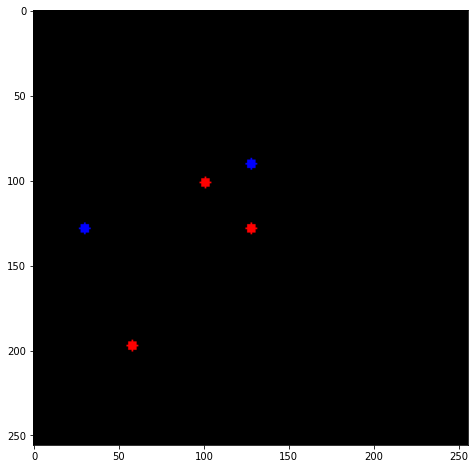

In [ ]:
img_points = np.zeros((256, 256, 3), np.uint8)

for pt in x:
    img_points = cv2.circle(img_points, pt[:2], 3, (0, 0, 255), -1)
for pt in y.T.astype(int):
    img_points = cv2.circle(img_points, pt[:2], 3, (255, 0, 0), -1)

plt.imshow(img_points)

In [ ]:
np_est_aff = y @ np.linalg.inv(x.T)
print(np_est_aff)

[[  0.70710678   0.70710678 -53.01933598]
 [ -0.70710678   0.70710678 128.        ]]


In [ ]:
angle = 45
rot_mat = np.array((
    [np.cos(angle * np.pi / 180), -np.sin(angle * np.pi / 180), 0],
    [np.sin(angle * np.pi / 180), np.cos(angle * np.pi / 180), 0],
    [0, 0, 1]
))
rot_mat @ np.array([0, 1, 1])

array([-0.70710678,  0.70710678,  1.        ])

[[  0.70710678   0.70710678 -53.01933598]
 [ -0.70710678   0.70710678 128.        ]] (2, 3)
[[  0.70710678   0.70710678 -53.01933598]
 [ -0.70710678   0.70710678 128.        ]] (2, 3)


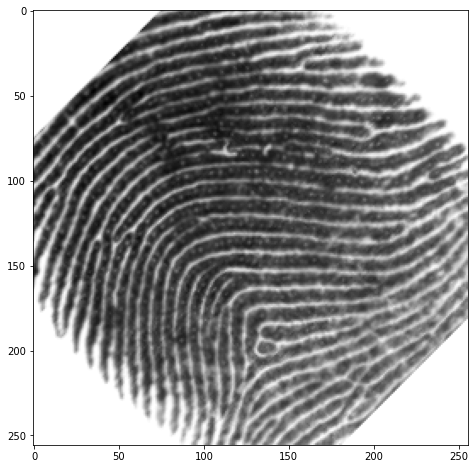

In [ ]:
rot_mat = cv2.getRotationMatrix2D(center, angle, scale)
print(rot_mat, rot_mat.shape)

tr_vec = np.array([[0, 0, tx], [0, 0, ty]])
aff_mat = rot_mat + tr_vec
print(aff_mat, rot_mat.shape)

img_aff = cv2.warpAffine(255 - img1, aff_mat, (256, 256))
img_aff = 255 - img_aff

plt.imshow(img_aff, cmap='gray')
# img_orig.shape

# Filtering

In [ ]:
ks = 9
kernel = np.ones((ks, ks)) / (ks*ks)
print(kernel)

[[0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]]


256 256


  0%|          | 0/248 [00:00<?, ?it/s]

255 255


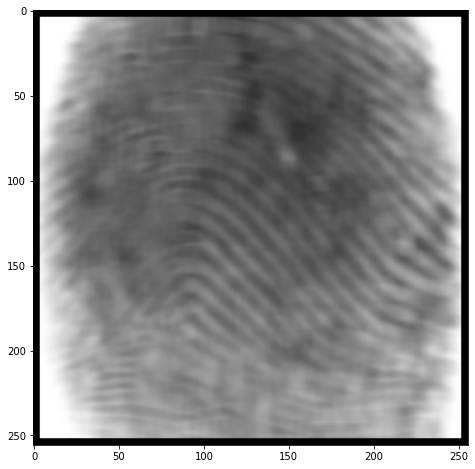

In [ ]:
rows, cols = img1.shape[:2]
print(rows, cols)
img_filtered = np.zeros(img1.shape, dtype=np.uint8)

for i in tqdm(range(ks//2,rows-ks//2)):
        for j in range(ks//2,cols-ks//2):
            # block = img[i-1:i+2,j-1:j+2]
            result = 0
            for k_i in range(0, len(kernel)):
                for k_j in range(0, len(kernel[0])):
                    # result += img1[i, j] * kernel[k_i, k_j]  # correlation
                    result += img1[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]  # convolution
            img_filtered[i, j] = int(result)

print(img1.max(), img_filtered.max())

plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
256 256


  0%|          | 0/254 [00:00<?, ?it/s]

255 255
CPU times: user 1.74 s, sys: 29.3 ms, total: 1.77 s
Wall time: 1.76 s


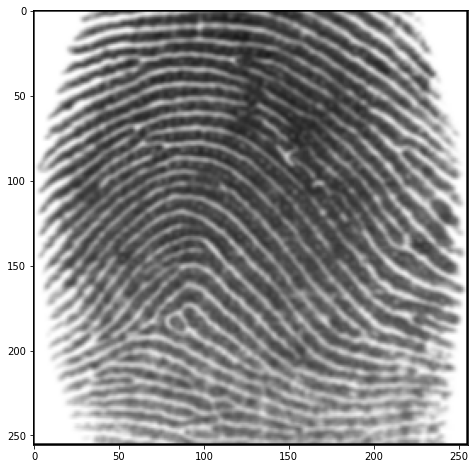

In [ ]:
%%time
ks = 3
kernel = np.ones((ks, ks)) / (ks*ks)
print(kernel)

rows, cols = img1.shape[:2]
print(rows, cols)
img_filtered = np.zeros(img1.shape, dtype=np.uint8)

for i in tqdm(range(1,rows-1)):
        for j in range(1,cols-1):
            # block = img[i-1:i+2,j-1:j+2]
            result = 0
            for k_i in range(0, len(kernel)):
                for k_j in range(0, len(kernel[0])):
                    # result += img1[i, j] * kernel[k_i, k_j]  # correlation
                    result += img1[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]  # convolution
            img_filtered[i, j] = int(result)

print(img1.max(), img_filtered.max())

plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
256 256


  0%|          | 0/254 [00:00<?, ?it/s]

255 255
CPU times: user 1.72 s, sys: 26.7 ms, total: 1.75 s
Wall time: 1.75 s


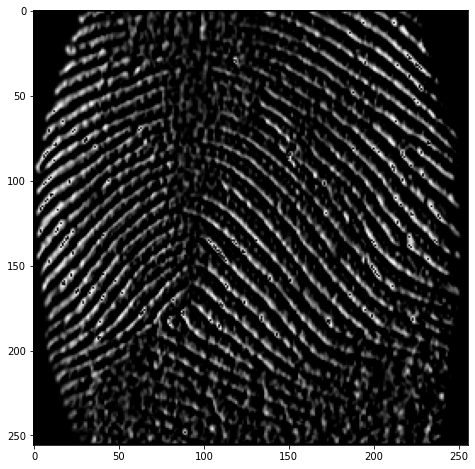

In [ ]:
%%time
ks = 3
# kernel = np.ones((ks, ks)) / (ks*ks)
kernel = np.array((
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
))
print(kernel)

rows, cols = img1.shape[:2]
print(rows, cols)
img_filtered = np.zeros(img1.shape, dtype=np.uint8)

for i in tqdm(range(1,rows-1)):
        for j in range(1,cols-1):
            # block = img[i-1:i+2,j-1:j+2]
            result = 0
            for k_i in range(0, len(kernel)):
                for k_j in range(0, len(kernel[0])):
                    # result += img1[i, j] * kernel[k_i, k_j]  # correlation
                    result += img1[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]  # convolution
            img_filtered[i, j] = int(result) if result > 0 else 0

print(img1.max(), img_filtered.max())

plt.imshow(cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB))

# feature extraction

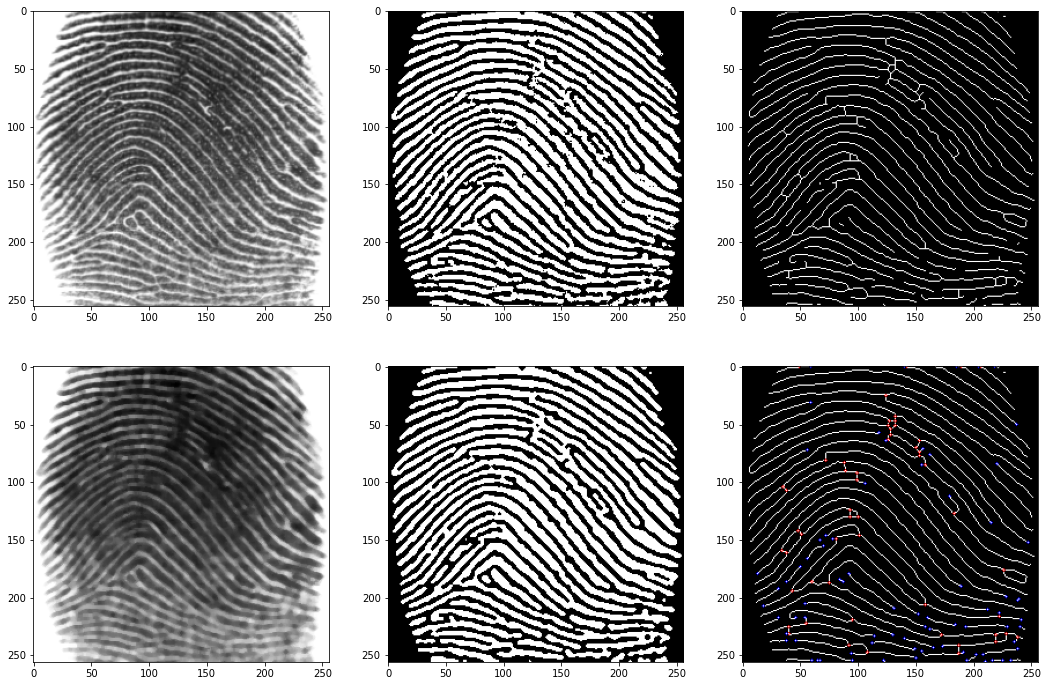

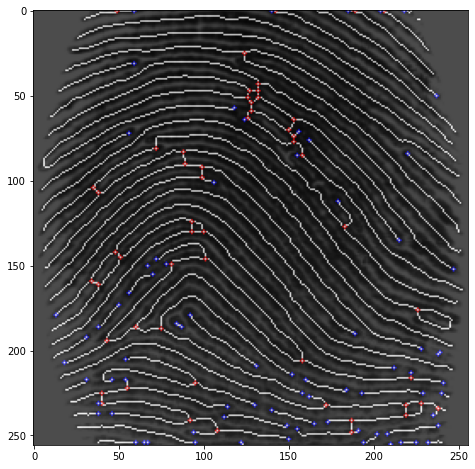

In [ ]:
feat_end, feat_bif = fp.get_fp_feature(img1, flg_show=True)

# Matching

In [ ]:
train_path = 'data/selected/train_ref'
test2_path = 'data/selected/test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 1428


data/selected/test2/100_type1.BMP 100 data/selected/train_ref/100.BMP


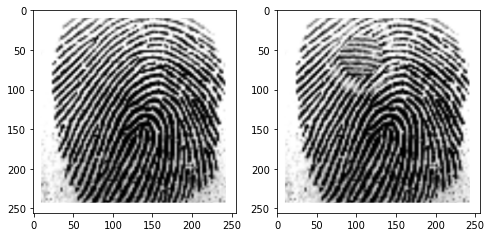

In [ ]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path)
img_test = cv2.imread(target_path)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')


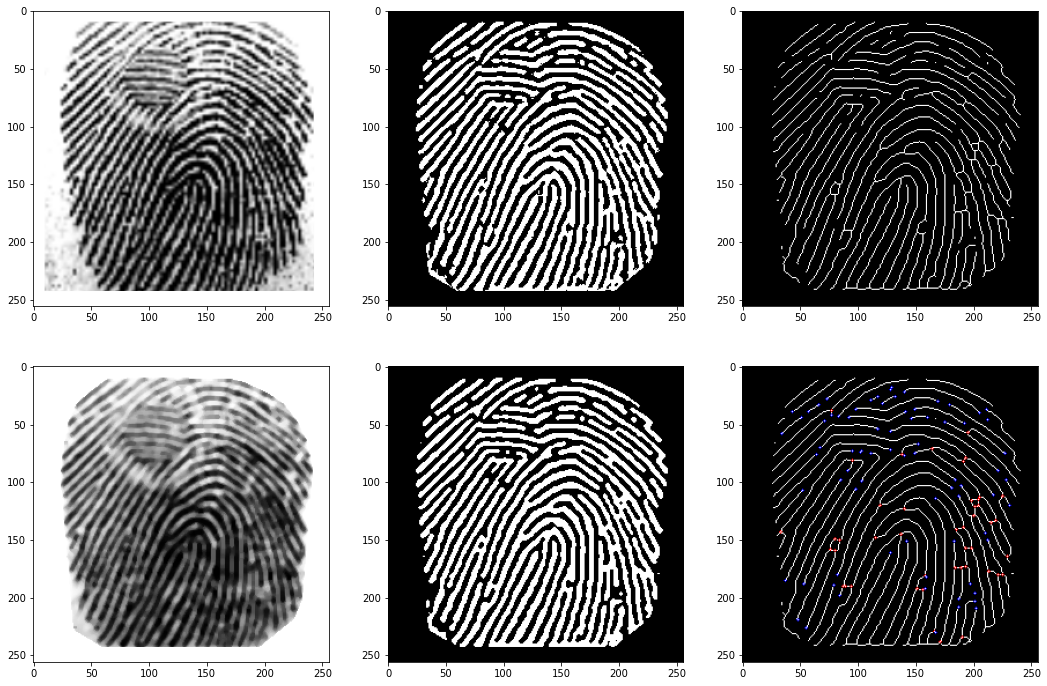

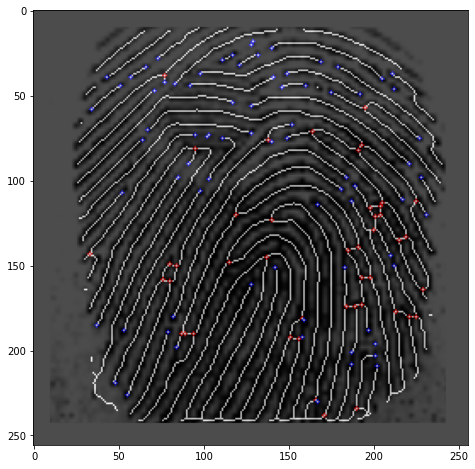

In [ ]:
q_end, q_bif = fp.get_fp_feature(img_test, flg_show=True)

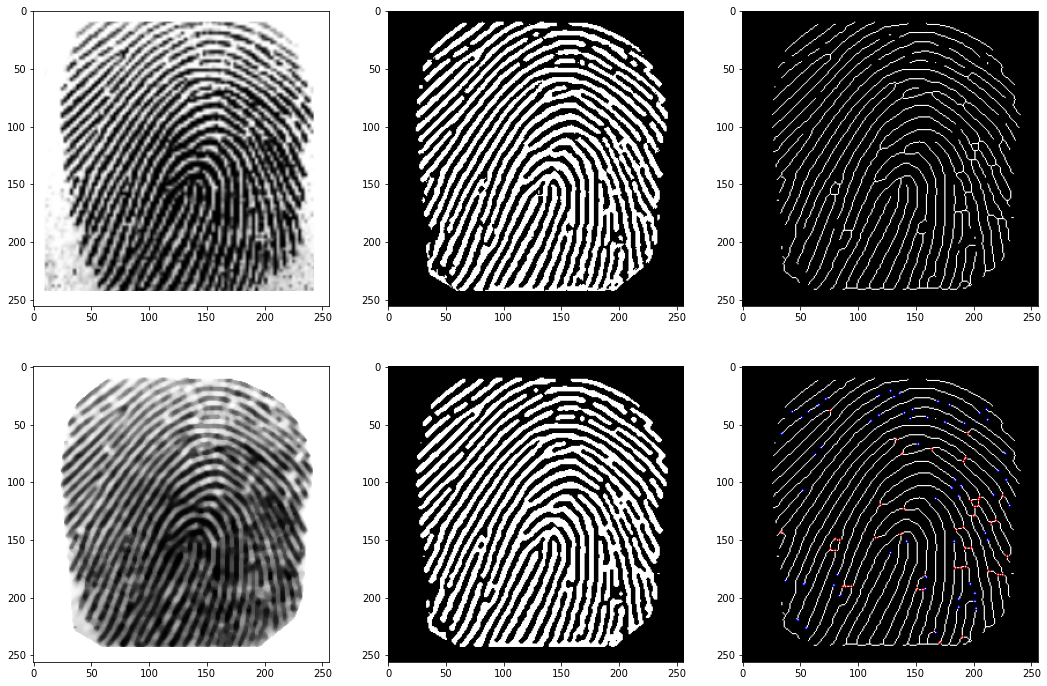

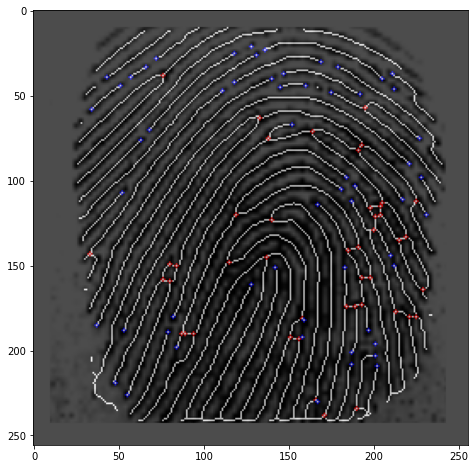

In [ ]:
db_end, db_bif = fp.get_fp_feature(img_train, flg_show=True)

In [ ]:
feat_query = np.concatenate([q_end, q_bif]).astype(np.uint8)
feat_train = np.concatenate([db_end, db_bif]).astype(np.uint8)

In [ ]:
print(len(feat_query), len(feat_train))

120 102


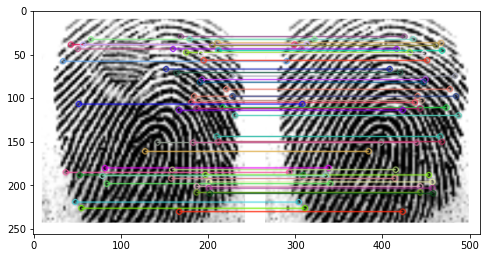

26.171077013015747 0.0 100


In [ ]:
dist, dist_half, len_match = fp.match_finger(feat_query, feat_train, 50, True, img_query=img_test, img_train=img_train)
print(dist, dist_half, len_match)

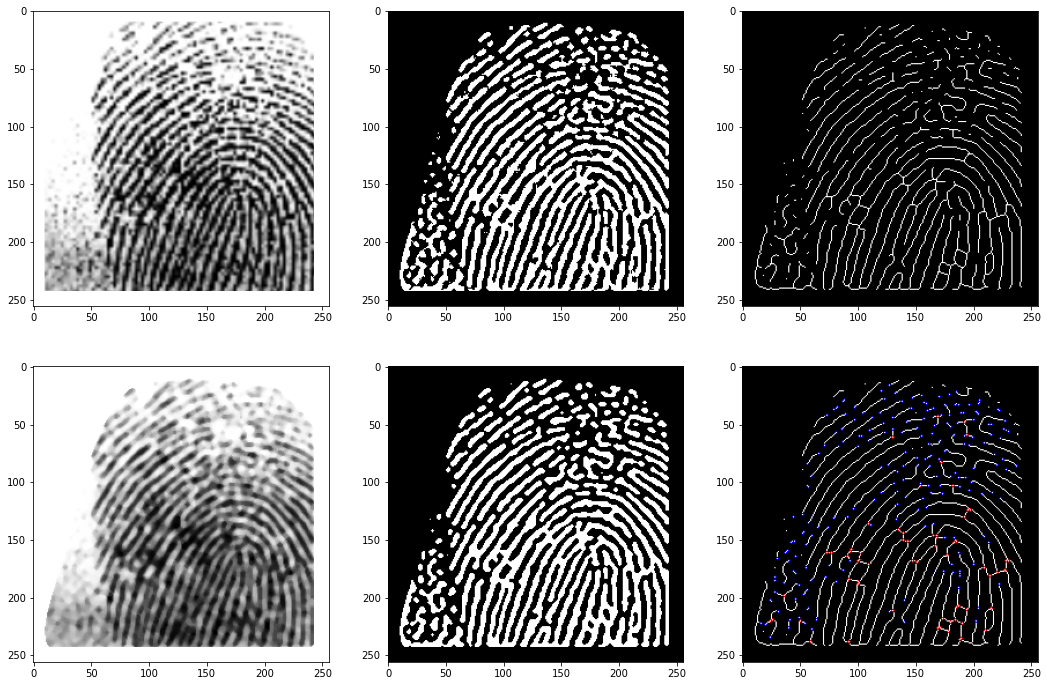

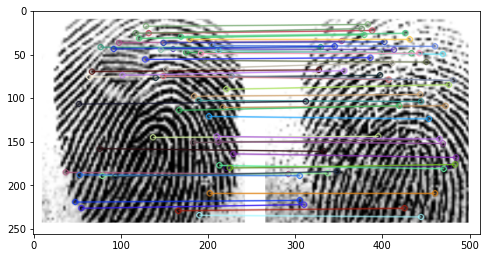

445.9393701553345 97.43551254272461 66


In [ ]:
img_train2 = cv2.imread(list_train[1])
db_x_end, db_x_bif = fp.get_fp_feature(img_train2, True)
feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
dist, dist_half, len_match = fp.match_finger(feat_query, feat_db_x, 50, True, img_query=img_test, img_train=img_train2)
print(dist, dist_half, len_match)

In [ ]:
dict_result = {}
for t in tqdm(list_train):
    basename = os.path.basename(t)
    img_train2 = cv2.imread(t)
    db_x_end, db_x_bif = fp.get_fp_feature(img_train2, False)
    feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
    dist, dist_half, len_match = fp.match_finger(feat_query, feat_db_x, 50, False, img_query=img_test, img_train=img_train2)
    # print(dist, dist_half)
    dict_result[basename] = [dist, dist_half, len_match, len(feat_query), len(feat_db_x)]

  0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
dict_result

{'1.BMP': [340.4480068683624, 93.74949765205383, 29, 120, 108],
 '10.BMP': [445.9393701553345, 97.43551254272461, 66, 120, 256],
 '100.BMP': [26.171077013015747, 0.0, 100, 120, 102],
 '101.BMP': [291.7629566192627, 75.43599700927734, 25, 120, 84],
 '102.BMP': [385.58453488349915, 83.91641306877136, 58, 120, 209],
 '104.BMP': [437.9827779531479, 122.91438138484955, 46, 120, 142],
 '105.BMP': [582.7907665967941, 143.5651491880417, 61, 120, 172],
 '106.BMP': [440.008132815361, 105.96008861064911, 57, 120, 176],
 '107.BMP': [253.74766266345978, 39.728816628456116, 29, 120, 103],
 '108.BMP': [404.53524565696716, 99.3465006351471, 43, 120, 121],
 '11.BMP': [349.80949807167053, 91.03306317329407, 32, 120, 72],
 '111.BMP': [446.70002341270447, 107.75078845024109, 43, 120, 123],
 '112.BMP': [301.3451189994812, 91.2564787864685, 46, 120, 198],
 '113.BMP': [403.71186435222626, 98.3516925573349, 56, 120, 239],
 '116.BMP': [455.36264646053314, 78.21514022350311, 45, 120, 131],
 '12.BMP': [235.12996

# other

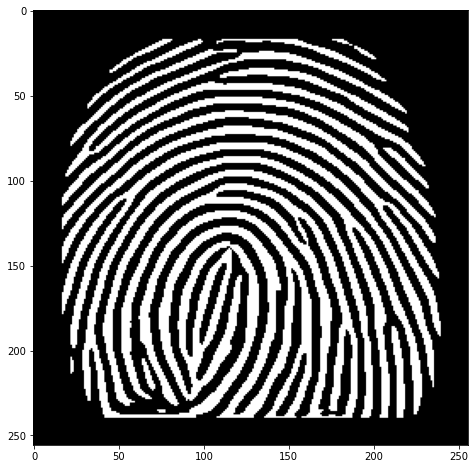